In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [2]:
#import alvra_tools
#print(alvra_tools.__file__)

In [3]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools.load_data import *
from alvra_tools.channels import *

[INFO][corrections] Numba not available, reverting to Numpy


In [4]:
# Take the correct pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals)
# Take the correct gains.h5 file (usually located in /sf/alvra/config/jungfrau/gainMaps/JF02T09V01/)

pede_file = "/sf/alvra/data/p17983/res/JF_pedestals/pedestal_20190723_1255.JF02T09V02.res.h5"

gain_file = "/sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5"

with h5py.File(gain_file, "r") as file: 
    G = file["gains"][:]
    
with h5py.File(pede_file, "r") as file: 
    P = file["gains"][:]
    mask = file["pixel_mask"][:]

print("Dimensions of G: ", G.shape)
print("Dimensions of P: ", P.shape)
print("Dimensions of mask: ", mask.shape)

# Detector name for loading module map and applying geometry
detector_name = "JF02T09V02"

Dimensions of G:  (4, 4608, 1024)
Dimensions of P:  (4, 4608, 1024)
Dimensions of mask:  (4608, 1024)


In [5]:
DIR = "/sf/alvra/data/p17983/raw/"

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

There are 64 files in the folder /sf/alvra/data/p17983/raw/


In [6]:
filename = "Ru_foil_XES_3keV_001.JF02T09V02.h5"
bsreadfile = "Ru_foil_XES_3keV_001.BSREAD.h5"

#user sets number of frames to combine
N_shots_to_use = 20

images, pulse_ids = load_JF_data_corrected(DIR + filename, G, P, mask, nshots=N_shots_to_use)

#this function assumes pump on/off handeling and we just forced everything into one of them and read it out
(DataFluo, _, IzeroFEL, _, BS_pulse_ids, _, _, _) = load_PumpProbe_events(DIR+bsreadfile, channel_BS_pulse_ids,nshots=N_shots_to_use*2)    
        


All modules are active


/sf/alvra/anaconda/dev/lib/python3.6/site-packages/jungfrau_utils/corrections.py:202: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  res = np.stack(partial_func_to_use(i) for i in image)


Right now it seems like the on and off data is flipped coming from the load_JF_data_on_off function.  Will need to fix this.  For now I am just coding is backwards.

In [7]:
nframes = images.shape[0]
print('number of frames')
print(nframes)
# nframes = 1

X = [a==b for a,b in zip(pulse_ids, BS_pulse_ids)]
if sum([int(x) for x in X]) == images.shape[0]:
    print('passed pulse id check')
else:
    print('failed pulse id check')
# print(images.shape)


number of frames
20
passed pulse id check


In [8]:
numstds = 2
minIzero = 0.002
image_threshold = 4
hot_pixel = 10

total = 0
# total_off = 0

IzeroMedian = np.median(IzeroFEL)
IzeroSTD = np.std(IzeroFEL)

# print(images_off.shape)
print('number of frames')
print(nframes)
    
conditionMax = IzeroFEL < IzeroMedian+numstds*IzeroSTD
conditionMin = IzeroFEL > IzeroMedian-numstds*IzeroSTD
conditionLow = IzeroFEL > minIzero
condition = np.logical_and.reduce((conditionLow, conditionMin, conditionMax)).T[0]
# if conditionMax and conditionMin and conditionLow:

# print(condition)

images_good = images[condition,...]
#         image_off = ju.apply_gain_pede(image_off, G=G, P=P, pixel_mask=mask, highgain=False)
images_thr = images_good.copy()
images_thr[images_good < image_threshold] = 0
images_thr[images_good > hot_pixel] = 0

total = images_thr.sum(axis=0)


# print(total.shape)


number of frames
20


(514, 9318)


<IPython.core.display.Javascript object>


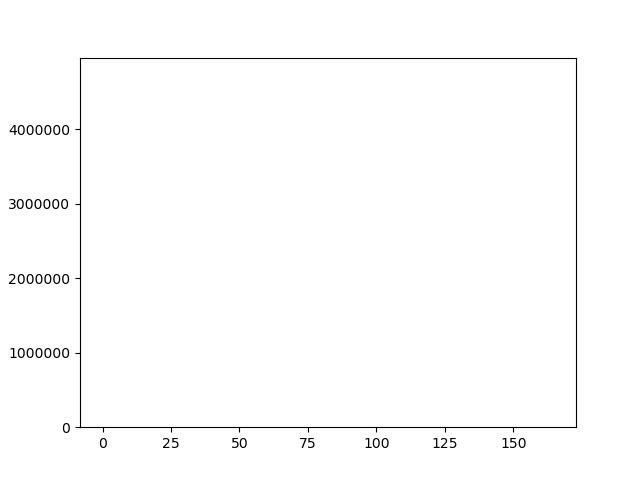

In [9]:
total_corr = ju.apply_geometry(total, detector_name)

print(total_corr.shape)

plt.figure()
_ = plt.hist(total_corr.ravel(),1000)

<IPython.core.display.Javascript object>


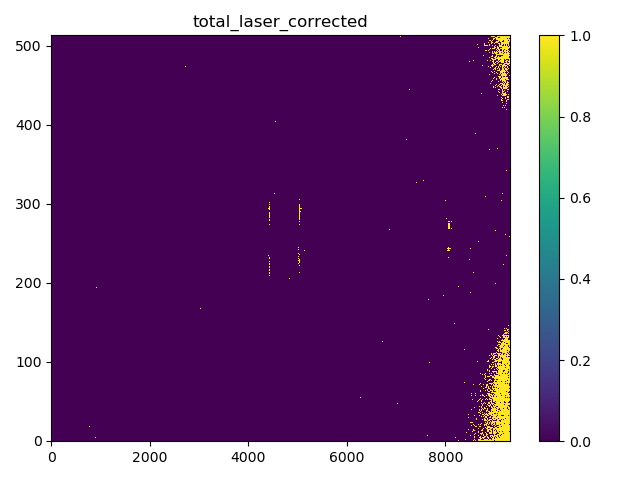

In [10]:
plt.figure()
# plt.imshow(total_off_corr, origin="lower", aspect='auto', vmin=0, vmax=1000)
plt.imshow(total_corr, origin="lower", aspect='auto', vmin=0, vmax=1)
plt.colorbar()
plt.title('total_laser_corrected')
plt.tight_layout()
plt.show()


1024
(4608, 1024)


<IPython.core.display.Javascript object>


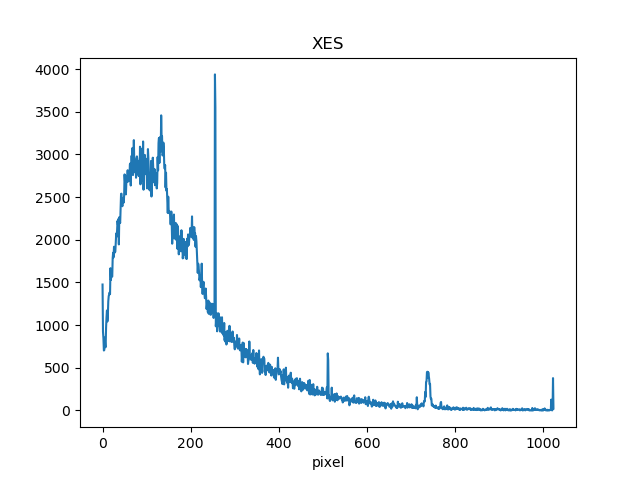

Text(0.5, 1.0, 'XES')

In [11]:
XES = np.sum(total,axis=0)
print(XES.size)
print(total.shape)

plt.figure()
plt.plot(XES)
plt.xlabel('pixel')
plt.title('XES')
